In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

from pathlib import Path

import matplotlib.pyplot as plt
import motorlab as ml
import numpy as np
import seaborn as sns
import yaml

In [ ]:
os.chdir(Path().resolve().parent)

In [ ]:
sessions = ml.sessions.GBYK
sns.set_theme(style="whitegrid")

In [ ]:
poses = dict()
intervals = dict()

for session in sessions:
    poses_dir = Path("data/gbyk/") / session / "poses"
    poses_ = ml.data.load_from_memmap(poses_dir)
    poses_ = ml.poses.change_representation(
        poses_,
        "centered",
        "gbyk",
    )
    poses[session] = poses_

    intervals[session] = dict()
    intervals_dir = Path(f"data/gbyk/{session}/intervals/")
    for i, meta_interval in enumerate(sorted(intervals_dir.iterdir())):
        intervals[session][i] = {
            "side": None,
            "start": None,
            "end": None,
            "type": None,
        }
        with open(meta_interval, "r") as f:
            meta_dict = yaml.safe_load(f)
            start = int(meta_dict["first_frame_idx"] // 50)
            end = start + int(meta_dict["num_frames"] // 50)
            intervals[session][i]["start"] = start
            intervals[session][i]["end"] = end
            intervals[session][i]["side"] = meta_dict["side"]
            intervals[session][i]["type"] = meta_dict["type"]

In [ ]:
test = ml.poses.compute_trunk(poses_, "gbyk")
kps_to_exclude = ["r_eye", "r_ear", "l_eye", "l_ear", "nose", "head", "e_tail"]
idxs = [ml.utils.KEYPOINTS["gbyk"][kp] for kp in kps_to_exclude]
test = test.reshape(-1, 21, 3)
test[:, idxs, :] = np.nan
test = test.reshape(-1, 63)

In [ ]:
s, e = intervals[session][0]["start"], intervals[session][0]["end"]
ml.plot.poses3d_improved(
    test[s:e],
    "gbyk",
    fps=50,
    save_path="test",
)

In [74]:
runs = {
    "allocentric": 20250729190213,
    "centered": 20250729191545,
    # "egocentric": 20250729184533,
    "egocentric": 20250805235055,
    "trunk": 20250729193028,
    "head": 20250729195943,
    "pc": 20250729153306,
    "loose": 20250729175541,
    "medium": 20250729180746,
    "strict": 20250729181925,
    "draconian": 20250729183336,
}

In [ ]:
test_intervals, _, _ = ml.intervals.load_all_by_tiers(
    data_dir="data/gbyk",
    sessions=ml.sessions.GBYK,
    experiment="gbyk",
    include_trial=True,
    include_homing=True,
    include_sitting=True,
)

In [76]:
results_dict = {
    "representation": [],
    "monkey": [],
    "type": [],
    "y_acc": [],
    "x_acc": [],
    "acc": [],
}

for representation, run in runs.items():
    config_path = Path(f"config/poses_to_position/{run}.yaml")

    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
        config["dataset"]["entire_trials"] = True
        config["dataset"]["batch_size"] = 1

    eval_metrics, eval_gts, eval_preds = ml.model.evaluate(config)

    for session in config["sessions"]:
        assert len(eval_gts[session]["position"]) == len(
            eval_preds[session]["position"]
        ), (
            f"GT and predictions for {session} have different lengths: "
            f"{len(eval_gts[session]['position'])} vs {len(eval_preds[session]['position'])}"
        )
        assert len(test_intervals[session]) == len(
            eval_gts[session]["position"]
        ), (
            f"Intervals for {session} have different lengths than GT: "
            f"{len(test_intervals[session])} vs {len(eval_gts[session]['position'])}"
        )
        for i in range(len(test_intervals[session])):
            gt = ml.room.get_tiles(
                eval_gts[session]["position"][i][:, 0],
                eval_gts[session]["position"][i][:, 1],
            )
            pred = ml.room.get_tiles(
                eval_preds[session]["position"][i][:, 0],
                eval_preds[session]["position"][i][:, 1],
            )
            acc = ml.metrics.balanced_accuracy(gt, pred)
            results_dict["acc"].append(acc)
            results_dict["x_acc"].append(
                ml.metrics.balanced_accuracy(gt, pred, group_by="x")
            )
            results_dict["y_acc"].append(
                ml.metrics.balanced_accuracy(
                    gt, pred, group_by="y", include_sitting=False
                )
            )
            results_dict["representation"].append(representation)
            results_dict["monkey"].append(session[:3])
            results_dict["type"].append(test_intervals[session][i].type)

/Users/caio/dev/motorlab/.mlab/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning:

A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.



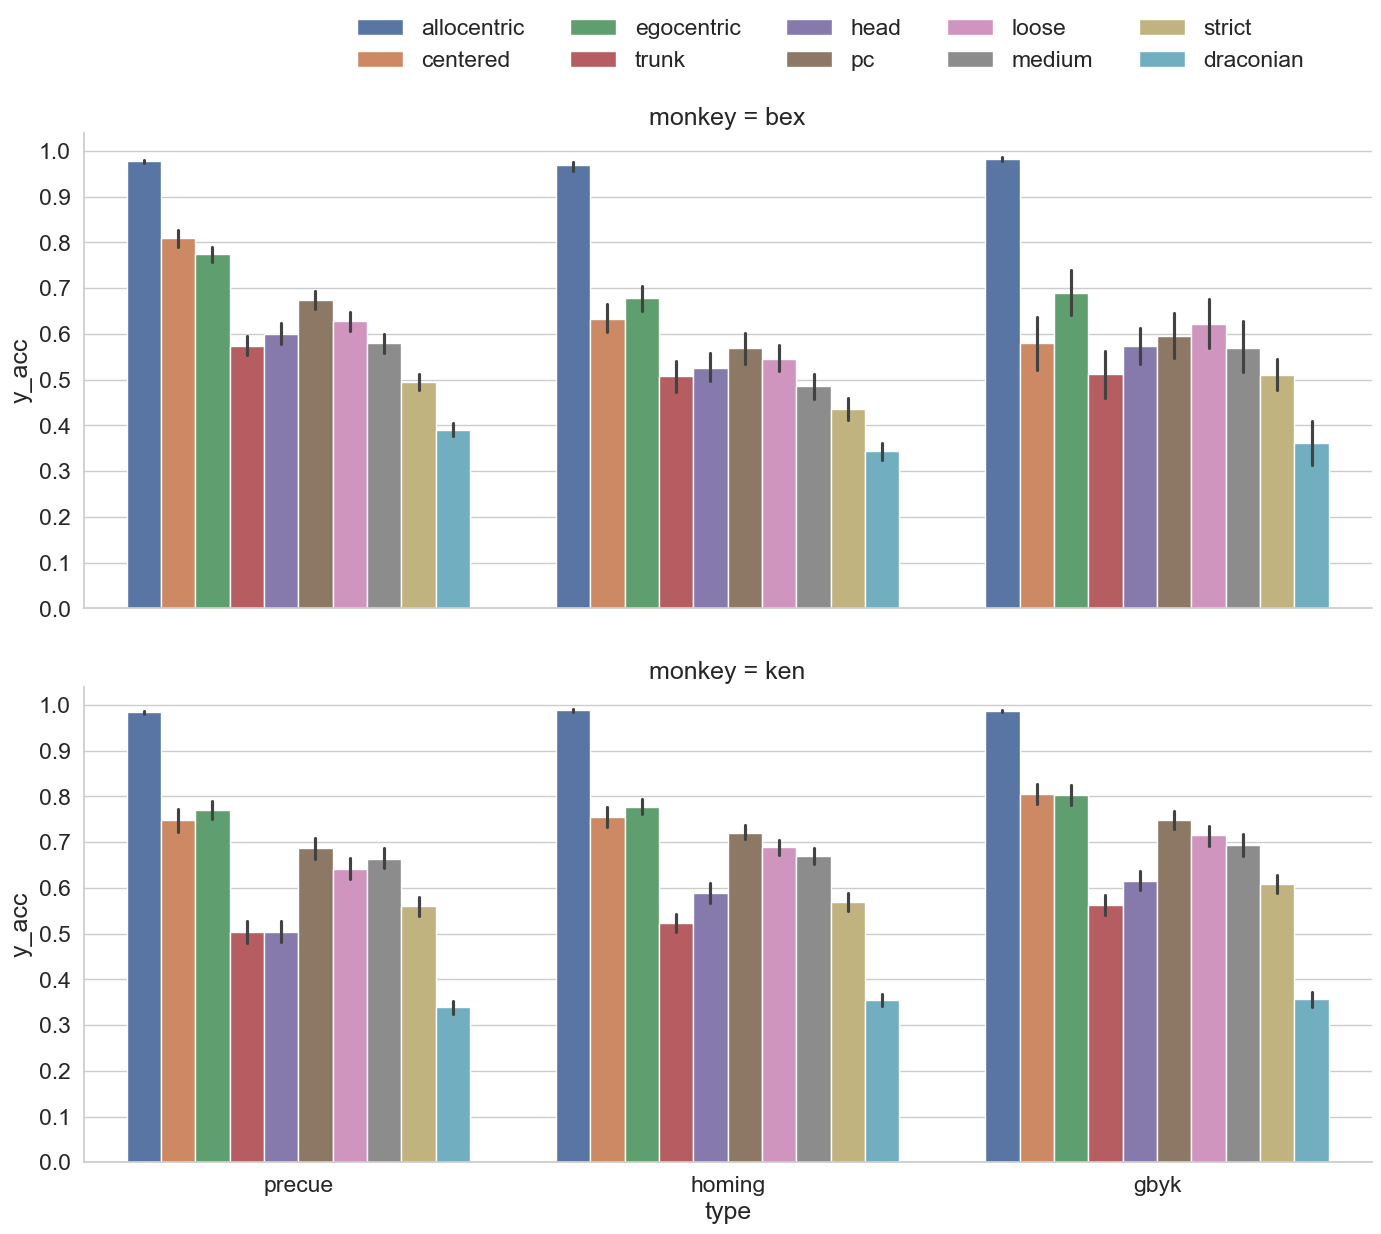

In [79]:
g = sns.catplot(
    data=results_dict,
    col="monkey",
    x="type",
    y="y_acc",
    hue="representation",
    kind="bar",
    col_wrap=1,
    hue_order=list(runs.keys()),
)

g.set(yticks=np.arange(0, 1.1, 0.1))
g.fig.set_size_inches(25, 12)
legend = g._legend
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]
legend.remove()
g.fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0.5, 1.02),
    loc="center",
    frameon=False,
    ncol=5,
    title="",
)

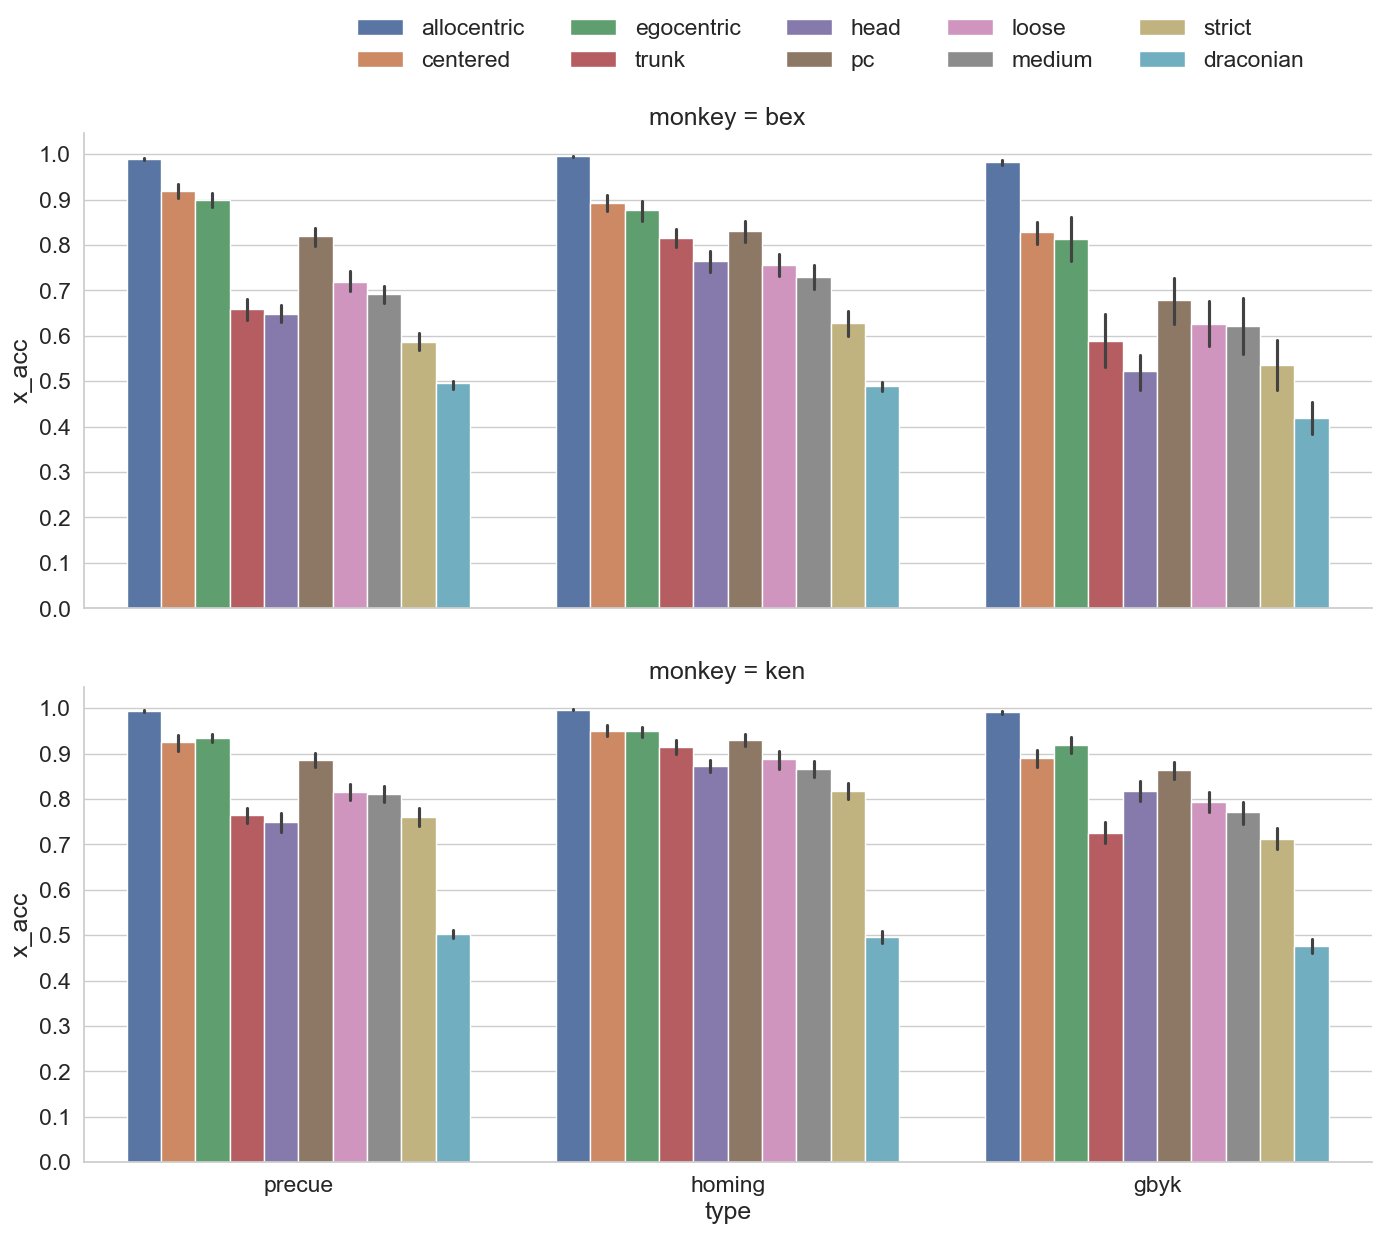

In [80]:
g = sns.catplot(
    data=results_dict,
    col="monkey",
    x="type",
    y="x_acc",
    hue="representation",
    kind="bar",
    col_wrap=1,
    hue_order=list(runs.keys()),
)

g.set(yticks=np.arange(0, 1.1, 0.1))
g.fig.set_size_inches(25, 12)
legend = g._legend
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]
legend.remove()
g.fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0.5, 1.02),
    loc="center",
    frameon=False,
    ncol=5,
    title="",
)